In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

# **AA_utils**

In [2]:
def graficar_curva_elbow(X, N, GMM=False):
    plt.figure()
    Nc = range(1, N+1)
    if (GMM):
        kmeans = [GaussianMixture(n_components=i) for i in Nc]
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    if (GMM):
        score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
        scoreBIC = [kmeans[i].fit(X).bic(X) for i in range(len(kmeans))]
    else:
        score = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]

    plt.plot(Nc, score, 'b')
    plt.xlabel('Number of Clusters')
    plt.title('Elbow Curve')
    plt.grid()
    if (GMM):
        plt.ylabel('log(verosimilitud)')
        plt.figure()
        plt.plot(Nc, scoreBIC, 'r--')
        plt.title('BIC Curve')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Bayesian information criterion')
        plt.grid()
    else:
        plt.ylabel('Promedio de sumas de distancias')
    plt.show()


# índice Silhouette
def graficar_indice_silhouette(X, N, GMM=False):

    plt.figure()
    Nc = range(2, N+1)
    if (GMM):
        # kmeans = [GaussianMixture(n_components=i) for i in Nc]
        print("Sin terminar silhouette para GMM")
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    score = [silhouette_score(X, kmeans[i].fit(X).predict(X))
             for i in range(len(kmeans))]
    score
    plt.plot(Nc, score)
    plt.xlabel('Número de Clusters')
    plt.ylabel('Promedio de índice silhouette')
    plt.title('Índice silhouette para distintos K')
    plt.grid()
    plt.show()


def graficar_indice_silhouette_k(X, n_clusters):

    # Compute the silhouette scores for each sample
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    plt.figure()
    ax1 = plt.gca()
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot para cada Cluster.")
    ax1.set_xlabel("Coeficientes silhouette")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()


def graficar_GMM(data, modelo, labels=False, probs=False):
    # display predicted scores by the model as a contour plot
    cant_points = 200
    x = np.linspace(min(data[:, 0])*0.9, max(data[:, 0])*1.1, cant_points)
    y = np.linspace(min(data[:, 1])*0.9, max(data[:, 1])*1.1, cant_points)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    if (probs):
        Z = np.exp(modelo.score_samples(XX))
    else:
        Z = -modelo.score_samples(XX)
    Z = Z.reshape(X.shape)

    centros = modelo.means_
    cant_gauss = centros.shape[0]
    if (probs):
        CS = plt.contour(X, Y, Z, levels=np.linspace(
            0, np.max(Z), cant_gauss*10),  linewidths=2)
        plt.title('Probabilidades de la GMM')
    else:
        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                         levels=np.logspace(0, 3, 20),  linewidths=2)
        plt.title('Negative log-likelihood de la GMM')
    plt.colorbar(CS, shrink=0.5)
    if (labels):
        etiq = modelo.predict(data)
        plt.scatter(data[:, 0], data[:, 1], s=30, c=etiq)
    else:
        plt.scatter(data[:, 0], data[:, 1], s=30)
    plt.scatter(centros[:, 0], centros[:, 1],
                marker='o', c='red', s=100, alpha=0.8)
    plt.grid()
    plt.axis('tight')
    plt.show()


def visualizar_clustering_2D(data, labels, centers):
    values = data.to_numpy()
    plt.figure()
    plt.scatter(values[:, 0], values[:, 1], c=labels, s=50, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1],
                marker='*', c='red', s=600, alpha=0.8)
    plt.show()


def graficar_DBSCAN_2D(data, labels, db, EPS, MINSAM, n_clusters_):
    plt.figure()
    noise_maks = labels == -1
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    # plot RUIDO
    x = data[noise_maks]  # datos RUIDO (outliers)
    plt.scatter(x[:, 0], x[:, 1], color=[0.2, 0.2, 0.2, 0.8],
                s=20, cmap='viridis', label='ruido', marker='x')
    # plot datos CORE en clusters
    x = data[~noise_maks & core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks &
                core_samples_mask], s=30, cmap='viridis', label='Cores')
    # plot datos NO CORE en clusters
    x = data[~noise_maks & ~core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks & ~core_samples_mask],
                s=20, cmap='viridis', label='Borders', marker='D')

    title = "eps= {}, min_samples= {}, #clusters= {}".format(
        EPS, MINSAM, n_clusters_)
    plt.title(title)
    plt.legend()
    plt.show()

# **DBSCAN**

**Density based spatial clustering of applications with noise**
(Agrupamiento espacial de aplicaciones con ruido basado en densidad)

**Ventajas:**
*   No necesita la definición de cantidad de clusters.
*   Se adapta mejor a formas no convexas.
*   Identifica outliers.
*   Reconoce regiones densas (con muchos datos) y las distingue de las
poco densas.
*   Se adecúa muy bien al agrupamiento intuitivo humano
*   Elemento de la lista

**Algoritmo**

*   **Epsilon**: distancia para considerar dos datos vecinos.
*   **Min_samples**: mínima cantidad de datos necesarios para considerarse un core sample.


*   Comienza con un dato aleatorio y analiza los vecinos que haya con un radio eps.
*   Si num_vecinos ≥ min_samples entonces el dato es considerado un
core sample. Si no existe el cluster, se crea.

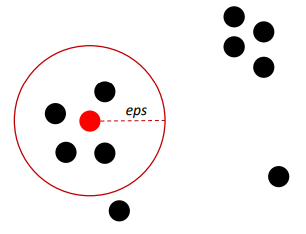

¡Cuidado! --> Al medir distancia, es susceptible a la escala de las variables!

*   Continúa con un vecino del cluster generado, aplicando el mismo procedimiento

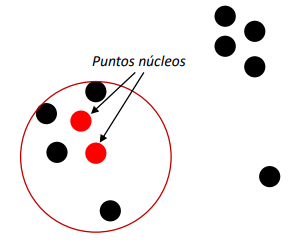

*   Si un vecino de un core sample no tiene suficientes vecinos para ser otro core sample del cluster, entonces es considerado un border point.

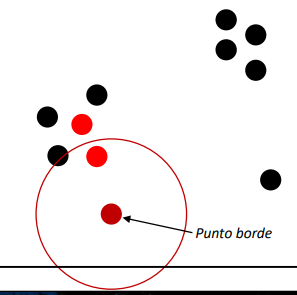

*   Continúa con el resto de vecinos hasta que se terminan.
*   Luego, comienza con un nuevo punto aleatorio y realiza el mismo procedimiento.

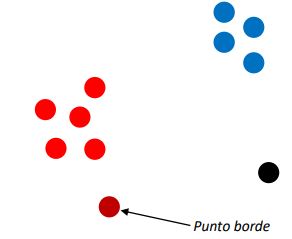

*   Si algún dato no tiene el mínimo de vecinos dentro del radio eps y no es vecino de ningún core sample entonces es considerado ruido (outlier).

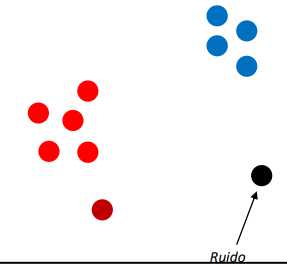

*   Al finalizar, el algoritmo detecta una cierta cantidad de clusters con sus puntos núcleo y puntos bordes y datos outliers que no pertenecen a ningún cluster.

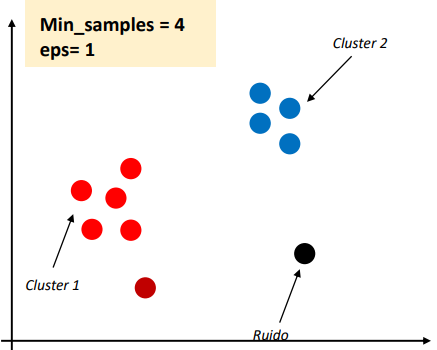


**Desventajas:**
*   Configurar eps y minsamples no es sencillo. Generalmente requiere experticia del dominio.
*   No se adapta bien a clusters de densidad variable, ya que todos los clusters comparten los hiperparámetros eps y minsamples. 
*   HDBSCAN soluciona parcialmente estos problemas.
*   Es muy sensible a los hiperparámetros. Pequeños cambios generan cambios
drásticos.
*   No es muy bueno con datos de alta dimensionalidad.
*   La interpretación del índice Silhouette no resulta del todo adecuado, ya que presupone clusters gaussianos.

**Ejemplos DBSCAN:**
https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

# **2D Moons**

**Carga del dataset**

In [3]:
df= pd.read_csv("https://raw.githubusercontent.com/KevinFDI/IML_Practica_4/main/datasets/2D_moons.csv") 
data = df.values

**Normalizo**

In [4]:
NORMALIZAR = 1
if (NORMALIZAR):
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)

**PARAM**

In [5]:
EPS = 0.3     # Epsilon: distancia para considerar dos datos vecinos.
MINSAM = 5    # Min_samples: mínima cantidad de datos necesarios para considerarse un core sample.

**Compute DBSCAN**

In [6]:
db = DBSCAN(eps=EPS, min_samples=MINSAM).fit(data)
labels = db.labels_

**Number of clusters in labels, ignoring noise if present**

In [7]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Num estimado de clusters: %d' % n_clusters_)
print('Num estimado de outliers: %d / %d total' % (n_noise_, len(data)))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(data, labels))

Num estimado de clusters: 2
Num estimado de outliers: 1 / 1000 total
Silhouette Coefficient: 0.295


**Visualizo la predicción**

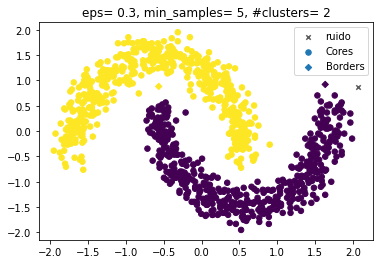

In [8]:
graficar_DBSCAN_2D(data, labels, db, EPS, MINSAM, n_clusters_)

**DBSCAN en sklearn**

In [9]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps= 0.5, min_samples = 5).fit(data) # Parámetros por defecto

labels = db.labels_ # Etiquetas de cada cluster. Sklearn pone -1 para datos con ruido

noise_maks= labels == -1

X_noise= data[noise_maks] # Filtramos los datos detectados como outliers.

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)

core_samples_mask[db.core_sample_indices_] = True 

X_coresamples= data[~noise_maks & core_samples_mask] # Filtramos los datos detectados como core samples.